In [1]:

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits import mplot3d
from tabulate import tabulate

from sklearn.ensemble import RandomForestRegressor
from sklearn.externals import joblib
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
 

%matplotlib notebook


In [2]:

# CURATE DATA

data_path = '20k_data.csv'
label_path = '20k_labels.csv'

data = pd.read_csv(data_path, low_memory=False)
label = pd.read_csv(label_path, low_memory=False)

headers = ['x', 'y', 'z']
num_objs = (data.shape[1] - 3) // 2

dists = []
heights = []
for i in range(num_objs):
    dists.append('dist_' + str(i))
    heights.append('height_' + str(i))
    headers.append('dist_' + str(i))
    headers.append('height_' + str(i))
    
data.columns = headers
data = data.replace(to_replace='None', value=0).astype('float')


In [3]:

# CURATE ONLY MAX HEIGHT DATA

h_col = data[heights].idxmax(axis=1)
h_ind = [data.columns.get_loc(c) for c in h_col]

data_mh_list = [data.iloc[i, [0, 1, 2, h_ind[i]-1, h_ind[i]]].tolist() for i in range(len(h_ind))]
mh_headers = ['x', 'y', 'z', 'dist', 'height']
mh = pd.DataFrame(data_mh_list, columns=mh_headers)
mhl = label.join(mh)

hitable_groups = mhl.groupby(lambda x: 'Hitable' if mhl.iloc[x]['f'] != 0 else 'Unhitable')
mhl_hit = hitable_groups.get_group('Hitable')
mhl_unhit = hitable_groups.get_group('Unhitable')

mhf = mhl.groupby('f').get_group(1.0) # Max Force only allows hitable
hitable = mhl['f'].mask(mhl['f'] > 0, 1)

# Non-linear
mh_squared = mh.copy().pow(2).rename(lambda x: x+'^2', axis='columns')
mh_non_zero = mh.copy()
num = mh_non_zero._get_numeric_data()
num[num < 0] = 0
mh_root = mh_non_zero.pow(.5).rename(lambda x: x+'_root', axis='columns')
mh_tan = mh.copy().applymap(lambda x: math.tan(x))
nl_mh_just_squared = pd.concat([mh, mh_squared], axis=1)
nl_mh = pd.concat([mh, mh_squared, mh_root], axis=1)
nl_mh_tan = pd.concat([mh, mh_squared, mh_root, mh_tan], axis=1)


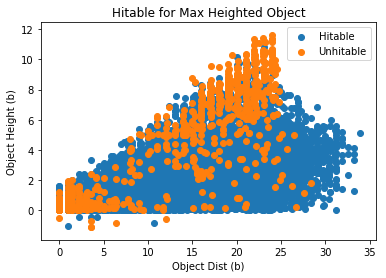

In [5]:

# CAN DETERMINE HITABLE FROM MAX HEIGHTED OBJECT

plt.figure(0)
for name, group in hitable_groups:
    plt.scatter(group['dist'], group['height'], label=name)    
plt.title('Hitable for Max Heighted Object')
plt.xlabel('Object Dist (b)')
plt.ylabel('Object Height (b)')
plt.legend()
plt.show()

# There seems to be some correlation between targets that are hitable and unhitable provided
# just he maximum heighted object. It does not look linarly seprable...


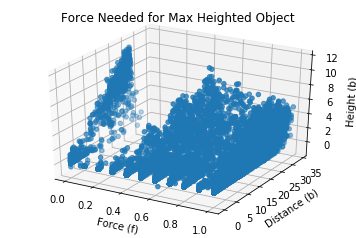

In [6]:

# FORCE PLOT MAX HEIGHTED OBJECT

figure = plt.figure(1).gca(projection='3d')
figure.scatter(mhl['f'], mhl['dist'], mhl['height'])
figure.set_title('Force Needed for Max Heighted Object')
figure.set_xlabel('Force (f)')
figure.set_ylabel('Distance (b)')
figure.set_zlabel('Height (b)')
plt.show()


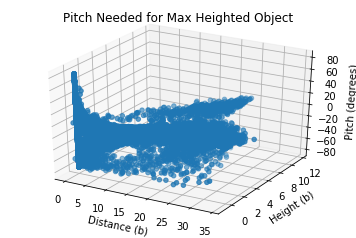

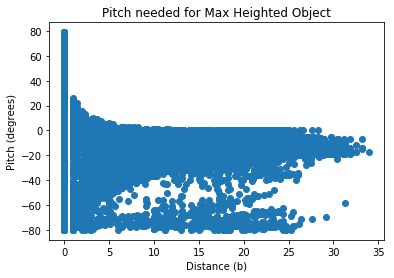

In [7]:

# PITCH PLOT MAX HEIGHTED OBJECT

figure = plt.figure(2).gca(projection='3d')
figure.scatter(mhl['dist'], mhl['height'], mhl['pitch'])
figure.set_title('Pitch Needed for Max Heighted Object')
figure.set_xlabel('Distance (b)')
figure.set_ylabel('Height (b)')
figure.set_zlabel('Pitch (degrees)')

figure = plt.figure(3)
plt.scatter(mhl['dist'], mhl['pitch'])
plt.title('Pitch needed for Max Heighted Object')
plt.xlabel('Distance (b)')
plt.ylabel('Pitch (degrees)')
plt.show()


Text(0.5,0,'Pitch (degrees)')

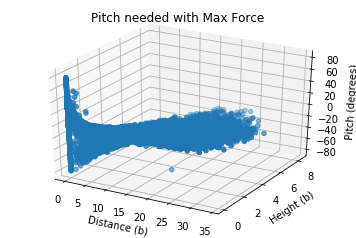

In [9]:

# DETERMINE PITCH FROM MAX FORCE MAX HEIGHTED OBJECT

figure = plt.figure(4).gca(projection='3d')
figure.scatter(mhf['dist'], mhf['height'], mhf['pitch'])
figure.set_title('Pitch needed with Max Force')
figure.set_xlabel('Distance (b)')
figure.set_ylabel('Height (b)')
figure.set_zlabel('Pitch (degrees)')


In [37]:
def neg_mean_sq_error(y_true, y_pred, sample_weight=None, multioutput='uniform_average'):
    return -1*(np.sum(np.abs(y_true - y_pred))/y_true.shape[0])

In [38]:
mean_sq_error = make_scorer(neg_mean_sq_error)

In [6]:

# RIDGE REGRESSION FOR PITCH ON MAX FORCE MAX HEIGHTED OBJECT

X = mhf[['x', 'y', 'z', 'dist', 'height']]
y = mhf['pitch']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42)

def target_dist(estimator, X, y, sample_weight=None):
    v0 = 3
    dist = np.sqrt(X['x']**2 + X['z']**2)
    pitch = estimator.predict(X)
    t_to_target = dist/(v0*np.cos(np.radians(-1*pitch)))
    arr_h = 1.62 + v0*np.sin(np.radians(-1*pitch))*t_to_target - 0.025*(t_to_target)**2
    return -1*np.average( abs(X['y'] + 0.5 - arr_h))

params = {'alpha': np.logspace(-5, 5, 11)}
ridge = Ridge()
grid = GridSearchCV(estimator=ridge, param_grid=params, scoring=target_dist, return_train_score=True)
grid.fit(X_train, y_train)

joblib.dump(grid.best_estimator_, 'Ridge_Pitch_MF_MHO_HIT.pkl')
columns = ['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']
print('BEST:', grid.best_score_, 'ALPHA:', grid.best_estimator_.alpha)
print(pd.DataFrame(grid.cv_results_)[columns])
#print(tabulate(pd.DataFrame(grid.cv_results_), headers='keys', tablefmt='psql'))

# Understandable scoring, this isn't terrible for Ridge. Could definately be 
# improved.
#
# BEST: 0.7887022927621963 ALPHA: 10.0


BEST: -1.1674269423651322 ALPHA: 10000.0
                 params  mean_train_score  mean_test_score  rank_test_score
0      {'alpha': 1e-05}         -1.412300        -1.415604               10
1     {'alpha': 0.0001}         -1.412300        -1.415604                9
2      {'alpha': 0.001}         -1.412300        -1.415604                8
3       {'alpha': 0.01}         -1.412299        -1.415603                7
4        {'alpha': 0.1}         -1.412294        -1.415598                6
5        {'alpha': 1.0}         -1.412241        -1.415544                5
6       {'alpha': 10.0}         -1.411713        -1.415007                4
7      {'alpha': 100.0}         -1.406575        -1.409796                3
8     {'alpha': 1000.0}         -1.365556        -1.368823                2
9    {'alpha': 10000.0}         -1.165206        -1.167427                1
10  {'alpha': 100000.0}         -1.693809        -1.694462               11


In [22]:
ridge = Ridge(alpha=10000)
ridge.fit(X_train, y_train)
preds = ridge.predict(X_test)
preds = pd.DataFrame(preds)
preds.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
red = pd.concat([preds, y_test], axis=1)
print(tabulate(red, headers='keys', tablefmt='psql'))

+------+--------------+---------+
|      |            0 |   pitch |
|------+--------------+---------|
|    0 |  -2.87885    |      -7 |
|    1 |  -3.62961    |      -6 |
|    2 | -26.3821     |     -22 |
|    3 | -16.8408     |     -16 |
|    4 |  -2.04064    |      -2 |
|    5 | -26.5186     |     -21 |
|    6 | -27.2958     |     -39 |
|    7 |  -4.81789    |      -5 |
|    8 |   5.24964    |       7 |
|    9 |  -8.336      |      -9 |
|   10 |  -8.55175    |      -8 |
|   11 | -14.3336     |     -14 |
|   12 | -21.4121     |     -22 |
|   13 | -27.2367     |     -26 |
|   14 | -16.7094     |     -17 |
|   15 |  -7.72102    |      -8 |
|   16 |  -8.78366    |     -10 |
|   17 |  -7.75648    |     -10 |
|   18 |  29.9561     |      21 |
|   19 | -13.1676     |     -12 |
|   20 | -22.0565     |     -23 |
|   21 |  -5.3045     |      -8 |
|   22 | -10.7562     |      -9 |
|   23 | -33.4799     |     -61 |
|   24 |   5.23616    |       9 |
|   25 | -14.6253     |     -13 |
|   26 | -24.9

In [7]:

# RIDGE REGRESSION FOR PITCH ON MAX HEIGHTED OBJECT HITABLE ONLY

X = mhl_hit[['x', 'y', 'z', 'dist', 'height']]
y = mhl_hit['pitch']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42)

params = {'alpha': np.logspace(-5, 5, 11)}
ridge = Ridge()
grid = GridSearchCV(estimator=ridge, param_grid=params, scoring=target_dist, return_train_score=True)
grid.fit(X_train, y_train)

joblib.dump(grid.best_estimator_, 'Ridge_Pitch_MHO_HIT.pkl')
columns = ['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']
print('BEST:', grid.best_score_, 'ALPHA:', grid.best_estimator_.alpha)
print(pd.DataFrame(grid.cv_results_)[columns])

# Okay, with the horrendous train score this new dataset with a varying
# force it seems that adding force causes the target function to no longer
# be linear in nature.
#
# BEST: 0.08124235068738328 ALPHA: 10.0


BEST: -6.713513151612618 ALPHA: 100000.0
                 params  mean_train_score  mean_test_score  rank_test_score
0      {'alpha': 1e-05}         -7.066491        -7.070505               11
1     {'alpha': 0.0001}         -7.066491        -7.070505               10
2      {'alpha': 0.001}         -7.066491        -7.070505                9
3       {'alpha': 0.01}         -7.066490        -7.070504                8
4        {'alpha': 0.1}         -7.066479        -7.070493                7
5        {'alpha': 1.0}         -7.066373        -7.070385                6
6       {'alpha': 10.0}         -7.065308        -7.069313                5
7      {'alpha': 100.0}         -7.054912        -7.058863                4
8     {'alpha': 1000.0}         -6.972870        -6.976304                3
9    {'alpha': 10000.0}         -6.775625        -6.779177                2
10  {'alpha': 100000.0}         -6.709611        -6.713513                1


In [8]:

# RIDGE REGRESSION FOR PITCH ON MAX HEIGHTED OBJECT

X = mhl[['x', 'y', 'z', 'dist', 'height']]
y = mhl['pitch']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42)

params = {'alpha': np.logspace(-5, 5, 11)}
ridge = Ridge()
grid = GridSearchCV(estimator=ridge, param_grid=params, scoring=target_dist, return_train_score=True)
grid.fit(X_train, y_train)

joblib.dump(grid.best_estimator_, 'Ridge_Pitch_MHO.pkl')
columns = ['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']
print('BEST:', grid.best_score_, 'ALPHA:', grid.best_estimator_.alpha)
print(pd.DataFrame(grid.cv_results_)[columns])

# It seems that attempting to predict the pitch with varying force AND incluing
# targets that cannot be hit reduces the ability to hit the target by over 50%.
# For the remainder of this section only hitable targets will be used.
#
# BEST: 0.02036305938423631 ALPHA: 100.0


BEST: -6.381479493971072 ALPHA: 10000.0
                 params  mean_train_score  mean_test_score  rank_test_score
0      {'alpha': 1e-05}         -6.411474        -6.412266               10
1     {'alpha': 0.0001}         -6.411474        -6.412266                9
2      {'alpha': 0.001}         -6.411474        -6.412266                8
3       {'alpha': 0.01}         -6.411474        -6.412266                7
4        {'alpha': 0.1}         -6.411473        -6.412265                6
5        {'alpha': 1.0}         -6.411463        -6.412255                5
6       {'alpha': 10.0}         -6.411366        -6.412158                4
7      {'alpha': 100.0}         -6.410406        -6.411197                3
8     {'alpha': 1000.0}         -6.402255        -6.403071                2
9    {'alpha': 10000.0}         -6.381343        -6.381479                1
10  {'alpha': 100000.0}         -6.443692        -6.443349               11


In [27]:

# RIDGE REGRESSION FOR PITCH/YAW/FORCE WITH MAX FORCE ON MAX HEIGHTED OBJECT

X = mhf[['x', 'y', 'z', 'dist', 'height']]
y = mhf[['pitch', 'yaw', 'f']]
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42)
def target_dist(estimator, X, y, sample_weight=None):
    dist = np.sqrt(X['x']**2 + X['z']**2).tolist()
    preds = estimator.predict(X)
    pitch = preds[:,0]
    v0 = preds[:,2]
    t_to_target = dist/(v0*np.cos(np.radians(-1*pitch)))
    arr_h = 1.62 + v0*np.sin(np.radians(-1*pitch))*t_to_target - 0.025*(t_to_target)**2
    yaw = abs(preds[:,1] - y['yaw'])
    return -1*np.average( np.sqrt(abs(X['y'] + 0.5 - arr_h)**2 + (dist*np.tan(yaw))**2))

params = {'alpha': np.logspace(-5, 5, 11)}
ridge = Ridge()
grid = GridSearchCV(estimator=ridge, param_grid=params, scoring=target_dist, return_train_score=True)
grid.fit(X_train, y_train)

joblib.dump(grid.best_estimator_, 'Ridge_Pitch_Yaw_Force_MF_MHO.pkl')
columns = ['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']
print('BEST:', grid.best_score_, 'ALPHA:', grid.best_estimator_.alpha)
print(pd.DataFrame(grid.cv_results_)[columns])

# Okay, there was a huge drop from calculating just the Pitch. Time to investigate
# and see which of the added two target parameters ruined the scoring. Probably the
# yaw as it's non-linear and ridge is a linear method.
#
# BEST: 0.5704921089542141 ALPHA: 100.0


BEST: -100.4054289316007 ALPHA: 1000.0
                 params  mean_train_score  mean_test_score  rank_test_score
0      {'alpha': 1e-05}       -112.165405      -151.731840               10
1     {'alpha': 0.0001}       -112.166258      -151.730010                9
2      {'alpha': 0.001}       -112.174882      -151.711831                8
3       {'alpha': 0.01}       -112.271375      -151.542896                7
4        {'alpha': 0.1}       -114.745549      -151.212240                6
5        {'alpha': 1.0}       -106.484602      -360.525822               11
6       {'alpha': 10.0}       -105.979421      -119.005054                3
7      {'alpha': 100.0}       -175.750975      -122.211802                4
8     {'alpha': 1000.0}       -105.994062      -100.405429                1
9    {'alpha': 10000.0}       -102.080173      -126.567331                5
10  {'alpha': 100000.0}       -166.940779      -106.507597                2


In [30]:

# RIDGE REGRESSION FOR YAW WITH MAX FORCE ON MAX HEIGHTED OBJECT

X = mhf[['x', 'y', 'z', 'dist', 'height']]
y = mhf['yaw']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42)

params = {'alpha': np.logspace(-5, 5, 11)}
ridge = Ridge()
grid = GridSearchCV(estimator=ridge, param_grid=params, scoring='neg_mean_absolute_error' , return_train_score=True)
grid.fit(X_train, y_train)

joblib.dump(grid.best_estimator_, 'Ridge_Yaw_MF_MHO.pkl')
columns = ['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']
print('BEST:', grid.best_score_, 'ALPHA:', grid.best_estimator_.alpha)
print(pd.DataFrame(grid.cv_results_)[columns])

# Target Function:
#     -180 * math.atan2(dx, dz) / math.pi
#
# This is understandable as the target function is not linear...
#
# BEST: 0.5640759291789648 ALPHA: 100.0


BEST: -49.99052456085978 ALPHA: 100000.0
                 params  mean_train_score  mean_test_score  rank_test_score
0      {'alpha': 1e-05}        -50.451387       -50.508433               11
1     {'alpha': 0.0001}        -50.451387       -50.508433               10
2      {'alpha': 0.001}        -50.451387       -50.508433                9
3       {'alpha': 0.01}        -50.451386       -50.508432                8
4        {'alpha': 0.1}        -50.451385       -50.508431                7
5        {'alpha': 1.0}        -50.451369       -50.508413                6
6       {'alpha': 10.0}        -50.451209       -50.508237                5
7      {'alpha': 100.0}        -50.449652       -50.506500                4
8     {'alpha': 1000.0}        -50.436786       -50.491253                3
9    {'alpha': 10000.0}        -50.351627       -50.399198                2
10  {'alpha': 100000.0}        -49.954268       -49.990525                1


In [34]:

# RIDGE REGRESSION FOR YAW WITH MAX FORCE AND JUST COORDS

X = mhf[['x', 'y', 'z']]
y = mhf['yaw']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42)

params = {'alpha': np.logspace(-5, 5, 11)}
ridge = Ridge()
grid = GridSearchCV(estimator=ridge, param_grid=params, scoring='neg_mean_absolute_error', return_train_score=True)
grid.fit(X_train, y_train)

joblib.dump(grid.best_estimator_, 'Ridge_Yaw_MF_COORDS.pkl')
columns = ['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']
print('BEST:', grid.best_score_, 'ALPHA:', grid.best_estimator_.alpha)
print(pd.DataFrame(grid.cv_results_)[columns])

# Target Function:
#     -180 * math.atan2(dx, dz) / math.pi
#
# Again, this is understandable as the target function is not linear.
# It also shows that the height and distance of the largest obstacle do
# not impact the yaw equation... which they clearly don't.
#
# BEST: 0.5636829559473956 ALPHA: 1000.0


BEST: -49.98427044358249 ALPHA: 100000.0
                 params  mean_train_score  mean_test_score  rank_test_score
0      {'alpha': 1e-05}        -50.447756       -50.482285               11
1     {'alpha': 0.0001}        -50.447756       -50.482285               10
2      {'alpha': 0.001}        -50.447756       -50.482285                9
3       {'alpha': 0.01}        -50.447756       -50.482285                8
4        {'alpha': 0.1}        -50.447755       -50.482284                7
5        {'alpha': 1.0}        -50.447746       -50.482275                6
6       {'alpha': 10.0}        -50.447656       -50.482186                5
7      {'alpha': 100.0}        -50.446763       -50.481294                4
8     {'alpha': 1000.0}        -50.437891       -50.472421                3
9    {'alpha': 10000.0}        -50.354569       -50.388671                2
10  {'alpha': 100000.0}        -49.952001       -49.984270                1


In [35]:

# RIDGE REGRESSION FOR YAW WITH MAX FORCE AND JUST XZ

X = mhf[['x', 'z']]
y = mhf['yaw']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42)

params = {'alpha': np.logspace(-5, 5, 11)}
ridge = Ridge()
grid = GridSearchCV(estimator=ridge, param_grid=params, scoring='neg_mean_absolute_error', return_train_score=True)
grid.fit(X_train, y_train)

joblib.dump(grid.best_estimator_, 'Ridge_Yaw_XZ.pkl')
columns = ['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']
print('BEST:', grid.best_score_, 'ALPHA:', grid.best_estimator_.alpha)
print(pd.DataFrame(grid.cv_results_)[columns])

# Target Function:
#     -180 * math.atan2(dx, dz) / math.pi
#
# This shows that the 'y' feature provides no information for the solution.
#
# BEST: 0.5637371520275183 ALPHA: 1000.0


BEST: -49.98444336552953 ALPHA: 100000.0
                 params  mean_train_score  mean_test_score  rank_test_score
0      {'alpha': 1e-05}        -50.447987       -50.479981               11
1     {'alpha': 0.0001}        -50.447987       -50.479981               10
2      {'alpha': 0.001}        -50.447987       -50.479981                9
3       {'alpha': 0.01}        -50.447986       -50.479981                8
4        {'alpha': 0.1}        -50.447986       -50.479980                7
5        {'alpha': 1.0}        -50.447977       -50.479971                6
6       {'alpha': 10.0}        -50.447886       -50.479880                5
7      {'alpha': 100.0}        -50.446982       -50.478971                4
8     {'alpha': 1000.0}        -50.438019       -50.469948                3
9    {'alpha': 10000.0}        -50.354808       -50.386658                2
10  {'alpha': 100000.0}        -49.952620       -49.984443                1


In [41]:

# RIDGE REGRESSION FOR FORCE ON MAX HEIGHTED OBJECT HITABLE ONLY

X = mhl_hit[['x', 'y', 'z', 'dist', 'height']]
y = mhl_hit['f']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42)

params = {'alpha': np.logspace(-5, 5, 11)}
ridge = Ridge()
grid = GridSearchCV(estimator=ridge, param_grid=params, scoring=mean_sq_error, return_train_score=True)
grid.fit(X_train, y_train)

joblib.dump(grid.best_estimator_, 'Ridge_Force_MHO_HIT.pkl')
columns = ['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']
print('BEST:', grid.best_score_, 'ALPHA:', grid.best_estimator_.alpha)
print(pd.DataFrame(grid.cv_results_)[columns])

# This is understandable as predicting pitch on the max heighted object not constrained
# to full force caused a dramatic decrease in score. This highly indicates that the resulting
# function needed to model this behavior is non-linear.
#
# BEST: 0.43837377420120976 ALPHA: 1e-05



BEST: -0.14233745998135916 ALPHA: 1e-05
                 params  mean_train_score  mean_test_score  rank_test_score
0      {'alpha': 1e-05}         -0.142263        -0.142337                1
1     {'alpha': 0.0001}         -0.142263        -0.142337                2
2      {'alpha': 0.001}         -0.142263        -0.142337                3
3       {'alpha': 0.01}         -0.142263        -0.142337                4
4        {'alpha': 0.1}         -0.142263        -0.142338                5
5        {'alpha': 1.0}         -0.142263        -0.142338                6
6       {'alpha': 10.0}         -0.142267        -0.142342                7
7      {'alpha': 100.0}         -0.142310        -0.142385                8
8     {'alpha': 1000.0}         -0.142839        -0.142904                9
9    {'alpha': 10000.0}         -0.148120        -0.148218               10
10  {'alpha': 100000.0}         -0.165055        -0.165119               11


In [16]:

# SVM TO DETERMINE IF HITABLE OR NOT MAXIMUM HEIGHTED OBJECT

X = mhl[['x', 'y', 'z', 'dist', 'height']]
X_train, X_test, y_train, y_test = train_test_split(X[:5000], 
                                                    hitable[:5000], 
                                                    test_size=0.33, 
                                                    random_state=42)

params = {
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'gamma': np.arange(0, 1, .1),
}
svc = SVC()
grid = GridSearchCV(estimator=svc, param_grid=params, return_train_score=True)
grid.fit(X_train, y_train)

joblib.dump(grid.best_estimator_, 'SVM_Hitable_MHO.pkl')
columns = ['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']
print('BEST:', grid.best_score_, 'PARAMS:', grid.best_params_)
print(pd.DataFrame(grid.cv_results_)[columns])

# While above it was determined that a plot of height and distance for the tallest object did
# not provide a linearly seprable looking dataset it was worth trying an SVM to determine if a target
# is hitable or not.
#
# As shown, the SVM was able to classify, based on the maximum heighted object, if the target was hittable
# or not 90ish percent of the time. The remaining ten percent of the time might be due to another object in
# the way.
#
# The best kernel to use is a non-linear kind. That doesn't mean the data isn't linearly seprable as the
# linear kernel gets comparable results. 
#
# BEST: 0.8934328358208955 PARAMS: {'gamma': 0.1, 'kernel': 'rbf'}


BEST: 0.8934328358208955 PARAMS: {'gamma': 0.1, 'kernel': 'rbf'}
                                               params  mean_train_score  \
0                  {'gamma': 0.0, 'kernel': 'linear'}          0.882237   
1                     {'gamma': 0.0, 'kernel': 'rbf'}          0.877015   
2                 {'gamma': 0.0, 'kernel': 'sigmoid'}          0.877015   
3                  {'gamma': 0.1, 'kernel': 'linear'}          0.882237   
4                     {'gamma': 0.1, 'kernel': 'rbf'}          0.943281   
5                 {'gamma': 0.1, 'kernel': 'sigmoid'}          0.770596   
6                  {'gamma': 0.2, 'kernel': 'linear'}          0.882237   
7                     {'gamma': 0.2, 'kernel': 'rbf'}          0.961341   
8                 {'gamma': 0.2, 'kernel': 'sigmoid'}          0.768507   
9   {'gamma': 0.30000000000000004, 'kernel': 'line...          0.882237   
10    {'gamma': 0.30000000000000004, 'kernel': 'rbf'}          0.968804   
11  {'gamma': 0.30000000000000004, 

In [28]:

# RIDGE REGRESSION FOR PITCH ON MAX HEIGHTED OBJECT (NONLINEARITY ADDED)

X = nl_mh_just_squared
y = mhl['pitch']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42)

params = {'alpha': np.logspace(-5, 5, 11)}
ridge = Ridge()
grid = GridSearchCV(estimator=ridge, param_grid=params, scoring=mean_sq_error, return_train_score=True)
grid.fit(X_train, y_train)

joblib.dump(grid.best_estimator_, 'Ridge_Pitch_MHO_NL.pkl')
columns = ['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']
print('BEST:', grid.best_score_, 'ALPHA:', grid.best_estimator_.alpha)
print(pd.DataFrame(grid.cv_results_)[columns])

# If you remember from before ridge regression produced the below results:
# BEST: 0.08124235068738328 ALPHA: 10.0
#
# It was theorized that what was created was a problem with a non-linear solution.
# After adding some non-linearity to the dataset. Mainly by adding the squares of each
# feature to the dataset. This resulted in a slight increase of accuracy from 8% to 12%.
# This increase shows there might be a non-linear fit to this data.
#
# Now these are new results:
# BEST: 0.1287202620999472 ALPHA: 1e-05


BEST: -17.451718443857857 ALPHA: 1000.0
                 params  mean_train_score  mean_test_score  rank_test_score
0      {'alpha': 1e-05}        -17.441727       -17.470938                9
1     {'alpha': 0.0001}        -17.441727       -17.470938                8
2      {'alpha': 0.001}        -17.441727       -17.470938                7
3       {'alpha': 0.01}        -17.441726       -17.470937                6
4        {'alpha': 0.1}        -17.441714       -17.470924                5
5        {'alpha': 1.0}        -17.441589       -17.470802                4
6       {'alpha': 10.0}        -17.440370       -17.469636                3
7      {'alpha': 100.0}        -17.430197       -17.460543                2
8     {'alpha': 1000.0}        -17.417516       -17.451718                1
9    {'alpha': 10000.0}        -17.500126       -17.534243               10
10  {'alpha': 100000.0}        -17.540884       -17.571865               11


In [29]:

# RIDGE REGRESSION FOR PITCH ON MAX HEIGHTED OBJECT (NON-LINEARITY ADDED)

X = nl_mh
y = mhl['pitch']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42)

params = {'alpha': np.logspace(-5, 5, 11)}
ridge = Ridge()
grid = GridSearchCV(estimator=ridge, param_grid=params, scoring=mean_sq_error, return_train_score=True)
grid.fit(X_train, y_train)

joblib.dump(grid.best_estimator_, 'Ridge_Pitch_MHO_NL_II.pkl')
columns = ['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']
print('BEST:', grid.best_score_, 'ALPHA:', grid.best_estimator_.alpha)
print(pd.DataFrame(grid.cv_results_)[columns])

# If you remember from before ridge regression produced the below results:
# BEST: 0.08124235068738328 ALPHA: 10.0
#
# With the addition of the square roots and squares of all the features the 
# accuracy jumped up from 8% to 14% leading more creditability to the fact this
# data might have a non-linear solution.
# 
# BEST: 0.14394117065908307 ALPHA: 1e-05


BEST: -17.23607944157414 ALPHA: 100.0
                 params  mean_train_score  mean_test_score  rank_test_score
0      {'alpha': 1e-05}        -17.217396       -17.251798                8
1     {'alpha': 0.0001}        -17.217396       -17.251798                7
2      {'alpha': 0.001}        -17.217395       -17.251798                6
3       {'alpha': 0.01}        -17.217389       -17.251792                5
4        {'alpha': 0.1}        -17.217334       -17.251737                4
5        {'alpha': 1.0}        -17.216789       -17.251202                3
6       {'alpha': 10.0}        -17.212598       -17.247081                2
7      {'alpha': 100.0}        -17.201874       -17.236079                1
8     {'alpha': 1000.0}        -17.259993       -17.294437                9
9    {'alpha': 10000.0}        -17.449239       -17.484094               10
10  {'alpha': 100000.0}        -17.524943       -17.555915               11


In [30]:

# RIDGE REGRESSION FOR YAW WITH ON MAX HEIGHTED OBJECT (NON-LINEARITY ADDED)

X = nl_mh
y = mhl['yaw']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42)

params = {'alpha': np.logspace(-5, 5, 11)}
ridge = Ridge()
grid = GridSearchCV(estimator=ridge, param_grid=params, scoring=mean_sq_error, return_train_score=True)
grid.fit(X_train, y_train)

joblib.dump(grid.best_estimator_, 'Ridge_Yaw_MF_MHO_NL.pkl')
columns = ['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']
print('BEST:', grid.best_score_, 'ALPHA:', grid.best_estimator_.alpha)
print(pd.DataFrame(grid.cv_results_)[columns])

# Without Non-linearity added: # BEST: 0.5640759291789648 ALPHA: 100.0
#
# Target Function:
#     -180 * math.atan2(dx, dz) / math.pi
#
# It's understandable that adding the square roots and squares of the data will not
# have a large impact on this problem as it requires atan2 in determining the final
# function which a simple addition of non-tan features will probably not impact significantly.
#
# BEST: 0.5884577385635079 ALPHA: 10.0

BEST: -50.18949046223618 ALPHA: 1000.0
                 params  mean_train_score  mean_test_score  rank_test_score
0      {'alpha': 1e-05}        -50.489289       -50.583482                9
1     {'alpha': 0.0001}        -50.489289       -50.583482                8
2      {'alpha': 0.001}        -50.489287       -50.583480                7
3       {'alpha': 0.01}        -50.489276       -50.583466                6
4        {'alpha': 0.1}        -50.489159       -50.583323                5
5        {'alpha': 1.0}        -50.487996       -50.581903                4
6       {'alpha': 10.0}        -50.476812       -50.568552                3
7      {'alpha': 100.0}        -50.382381       -50.466674                2
8     {'alpha': 1000.0}        -50.123055       -50.189490                1
9    {'alpha': 10000.0}        -50.812157       -50.851422               10
10  {'alpha': 100000.0}        -51.248795       -51.279599               11


In [42]:

# RIDGE REGRESSION FOR YAW WITH ON MAX HEIGHTED OBJECT (NON-LINEARITY ADDED II)

X = nl_mh_tan
y = mhl['yaw']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42)

params = {'alpha': np.logspace(-5, 5, 11)}
ridge = Ridge()
grid = GridSearchCV(estimator=ridge, param_grid=params, scoring=mean_sq_error, return_train_score=True)
grid.fit(X_train, y_train)

joblib.dump(grid.best_estimator_, 'Ridge_Yaw_MF_MHO_NLII.pkl')
columns = ['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']
print('BEST:', grid.best_score_, 'ALPHA:', grid.best_estimator_.alpha)
print(pd.DataFrame(grid.cv_results_)[columns])

# Without Non-linearity added: # BEST: 0.5640759291789648 ALPHA: 100.0
#
# Target Function:
#     -180 * math.atan2(dx, dz) / math.pi
#
# It seems that even tan objects do not impact the accuracy of ridge regression. There
# might be a better feature to add.
#
# BEST: 0.5886464334562715 ALPHA: 10.0


BEST: -50.124766673949956 ALPHA: 1000.0
                 params  mean_train_score  mean_test_score  rank_test_score
0      {'alpha': 1e-05}        -50.423277       -50.564086                9
1     {'alpha': 0.0001}        -50.423276       -50.564086                8
2      {'alpha': 0.001}        -50.423275       -50.564084                7
3       {'alpha': 0.01}        -50.423263       -50.564069                6
4        {'alpha': 0.1}        -50.423144       -50.563924                5
5        {'alpha': 1.0}        -50.421955       -50.562475                4
6       {'alpha': 10.0}        -50.410375       -50.548829                3
7      {'alpha': 100.0}        -50.311287       -50.441928                2
8     {'alpha': 1000.0}        -50.012041       -50.124767                1
9    {'alpha': 10000.0}        -50.613144       -50.687301               10
10  {'alpha': 100000.0}        -51.037149       -51.093861               11


In [44]:

# RIDGE REGRESSION FOR PITCH ON MAX HEIGHTED OBJECT (NON-LINEARITY ADDED II)

X = nl_mh_tan
y = mhl['pitch']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42)

params = {'alpha': np.logspace(-5, 5, 11)}
ridge = Ridge()
grid = GridSearchCV(estimator=ridge, param_grid=params, scoring=mean_sq_error, return_train_score=True)
grid.fit(X_train, y_train)

joblib.dump(grid.best_estimator_, 'Ridge_Pitch_MHO_HIT.pkl')
columns = ['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']
print('BEST:', grid.best_score_, 'ALPHA:', grid.best_estimator_.alpha)
print(pd.DataFrame(grid.cv_results_)[columns])

# If you remember from before ridge regression produced the below results:
# BEST: 0.08124235068738328 ALPHA: 10.0
#
# From previous non-linearity
# BEST: 0.14394117065908307 ALPHA: 1e-05
#
# With the addition of tan there is no increase in accuracy. This means that adding
# the tan of each componenet does not add any meaningful information for the problem.
#
# BEST: 0.1434521836415034 ALPHA: 1e-05


BEST: -17.25958442506304 ALPHA: 100.0
                 params  mean_train_score  mean_test_score  rank_test_score
0      {'alpha': 1e-05}        -17.220478       -17.273016                8
1     {'alpha': 0.0001}        -17.220478       -17.273016                7
2      {'alpha': 0.001}        -17.220478       -17.273016                6
3       {'alpha': 0.01}        -17.220473       -17.273011                5
4        {'alpha': 0.1}        -17.220421       -17.272961                4
5        {'alpha': 1.0}        -17.219920       -17.272477                3
6       {'alpha': 10.0}        -17.216147       -17.268790                2
7      {'alpha': 100.0}        -17.206284       -17.259584                1
8     {'alpha': 1000.0}        -17.263603       -17.314167                9
9    {'alpha': 10000.0}        -17.447705       -17.497575               10
10  {'alpha': 100000.0}        -17.527148       -17.570555               11


In [45]:

# RANDOM FOREST FOR PITCH ON MAX HEIGHTED OBJECT ONLY MAX FORCE

X = mhf[['x', 'y', 'z', 'dist', 'height']]
y = mhf['pitch']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42)

params = {
    'max_depth': [None],#, 1, 80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000],
}
rf = RandomForestRegressor()
grid = GridSearchCV(estimator=rf, param_grid=params, return_train_score=True, scoring=mean_sq_error)
grid.fit(X_train, y_train)

#joblib.dump(grid.best_estimator_, 'RF_Pitch_MHO_FO.pkl')
columns = ['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']
print('BEST:', grid.best_score_, 'MAX_DEPTH:', grid.best_estimator_.max_depth)
print(pd.DataFrame(grid.cv_results_)[columns])

# The best accuracy for ridge regression:
# BEST: 0.7887022927621963 ALPHA: 10.0
#
# Random Forest provides a much better accuracy then that of ridge regression.
# The amount of loss provided might be due to the fact there are some instances
# the player needs to know about the second heighest object.
#
# BEST: 0.9840397046277081 MAX_DEPTH: None


BEST: -1.1498314449983487 MAX_DEPTH: None
                                               params  mean_train_score  \
0   {'max_depth': None, 'max_features': 2, 'min_sa...         -1.028267   
1   {'max_depth': None, 'max_features': 2, 'min_sa...         -1.018463   
2   {'max_depth': None, 'max_features': 2, 'min_sa...         -1.029605   
3   {'max_depth': None, 'max_features': 2, 'min_sa...         -1.022419   
4   {'max_depth': None, 'max_features': 2, 'min_sa...         -1.070775   
5   {'max_depth': None, 'max_features': 2, 'min_sa...         -1.069492   
6   {'max_depth': None, 'max_features': 2, 'min_sa...         -1.080855   
7   {'max_depth': None, 'max_features': 2, 'min_sa...         -1.073177   
8   {'max_depth': None, 'max_features': 2, 'min_sa...         -1.150046   
9   {'max_depth': None, 'max_features': 2, 'min_sa...         -1.130144   
10  {'max_depth': None, 'max_features': 2, 'min_sa...         -1.141474   
11  {'max_depth': None, 'max_features': 2, 'min_sa...     

In [46]:
pd.set_option('display.max_rows', 1000)
print(pd.DataFrame(grid.cv_results_).ix[38])

mean_fit_time                                                        2.09584
mean_score_time                                                     0.104796
mean_test_score                                                     -1.15517
mean_train_score                                                    -0.79294
param_max_depth                                                         None
param_max_features                                                         3
param_min_samples_leaf                                                     3
param_min_samples_split                                                    8
param_n_estimators                                                       300
params                     {'max_depth': None, 'max_features': 3, 'min_sa...
rank_test_score                                                            3
split0_test_score                                                   -1.13688
split0_train_score                                                 -0.795213

c:\users\denis\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [47]:
rf_est = RandomForestRegressor(max_depth=None, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300)
rf_est.fit(X_train, y_train)
preds = rf_est.predict(X_test)
preds = list(preds)
ytest = list(y_test)
print(pd.DataFrame([preds,ytest]))

       0         1          2          3         4          5          6     \
0 -6.028496 -5.499673 -21.395175 -15.784722 -1.768834 -21.521429 -38.040925   
1 -7.000000 -6.000000 -22.000000 -16.000000 -2.000000 -21.000000 -39.000000   

       7         8         9      ...         3524       3525       3526  \
0 -5.035155  7.952275 -8.244982   ...   -17.555641 -14.784475 -25.886111   
1 -5.000000  7.000000 -9.000000   ...   -17.000000 -15.000000 -26.000000   

        3527       3528      3529      3530      3531       3532    3533  
0 -16.861151  25.692249 -11.02913  8.000734 -24.71977 -22.393564 -19.046  
1 -17.000000  23.000000  -8.00000  7.000000 -23.00000 -22.000000 -19.000  

[2 rows x 3534 columns]


In [48]:

# RANDOM FOREST FOR PITCH ON MAX HEIGHTED OBJECT

X = mh
y = mhl['pitch']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42)

params = {
    'max_depth': [None, 1, 80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000],
}

rf = RandomForestRegressor()
grid = GridSearchCV(estimator=rf, param_grid=params, scoring=mean_sq_error, return_train_score=True)
grid.fit(X_train, y_train)

joblib.dump(grid.best_estimator_, 'models/RF_Pitch_MHO.pkl')
columns = ['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']
print('BEST:', grid.best_score_, 'MAX_DEPTH:', grid.best_estimator_.max_depth)
print(pd.DataFrame(grid.cv_results_)[columns])

# Best Ridge Regression:
# BEST: 0.02036305938423631 ALPHA: 100.0
#
# Random Forest dramatically increases the accuracy of the for this problem.
# Strightly speaking, non-linearity is not the issue here. There might not be enough
# information in just the maximum heighted object to provide a solid answer.
#
# BEST: 0.2851125052791336 MAX_DEPTH: None


KeyboardInterrupt: 

In [85]:

# RANDOM FOREST FOR PITCH

X = data
y = label['pitch']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42)

params = {
    'max_depth': [None, 1, 80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000],
}

rf = RandomForestRegressor()
grid = GridSearchCV(estimator=rf, param_grid=params, return_train_score=True)
grid.fit(X_train, y_train)

joblib.dump(grid.best_estimator_, 'models/RF_Pitch.pkl')
columns = ['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']
print('BEST:', grid.best_score_, 'MAX_DEPTH:', grid.best_estimator_.max_depth)
print(pd.DataFrame(grid.cv_results_)[columns])

#
# Using all data only slightly increased the accurracy of the model. The
# amount of increase is not significant enough to determine if the additional data
# was strictly the cause of the increase. 
#
# BEST: 0.295552759961869 MAX_DEPTH: None


BEST: 0.2911783614856431 MAX_DEPTH: None
                params  mean_train_score  mean_test_score  rank_test_score
0  {'max_depth': None}          0.873763         0.291178                1
1     {'max_depth': 1}          0.038090         0.036408                2


In [86]:

# RANDOM FOREST FOR YAW ON MAX HEIGHTED OBJECT

X = mh
y = mhl['yaw']
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.33, 
                                                    random_state=42)

params = {
    'max_depth': [None, 1, 80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000],
}

#params = {'max_depth': [None, 1]}

rf = RandomForestRegressor()
grid = GridSearchCV(estimator=rf, param_grid=params, return_train_score=True)
grid.fit(X_train, y_train)

joblib.dump(grid.best_estimator_, 'models/RF_Yaw_MH.pkl')
columns = ['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']
print('BEST:', grid.best_score_, 'MAX_DEPTH:', grid.best_estimator_.max_depth)
print(pd.DataFrame(grid.cv_results_)[columns])

# Best from Ridge Regression:
# BEST: 0.5886464334562715 ALPHA: 10.0
#
# Using a non-linear model was accuratly able to model the yaw
# using the maximum height obstacle.
#
# BEST: 0.9119842493341669 MAX_DEPTH: None


BEST: 0.9119842493341669 MAX_DEPTH: None
                params  mean_train_score  mean_test_score  rank_test_score
0  {'max_depth': None}          0.984097         0.911984                1
1     {'max_depth': 1}          0.671965         0.671683                2
